In [1]:
import numpy as np
from glob import glob
from treem import Morph, SWC
from scipy.optimize import curve_fit

In [2]:
def load_segdata(reconstruction):
    m = Morph(reconstruction)
    d = dict()
    for i, t, x, y, z, r, p in m.data:
        i, t, x, y, z, r, p = int(i), int(t), x, y, z, r, int(p)
        d[i] = {'t': t, 'x': x, 'y': y, 'z': z, 'r': r, 'p': p}
    
    center = m.root.coord()
    for node in m.root.walk():
        if node.type() == SWC.SOMA:
            ident = node.ident()
            d[ident]['xsec'] = 0.0
            d[ident]['order'] = 0
            d[ident]['length'] = 0.0
            d[ident]['dist'] = 0.0
            d[ident]['path'] = 0.0
            d[ident]['breadth'] = 0
            d[ident]['totlen'] = 0.0

    for stem in m.stems():
        for sec in stem.sections():
            order = 1
            xsec = 0.0
            for node in sec:
                ident = node.ident()
                length = node.length()
                xsec += length
                if node.parent.is_fork() and node.parent != m.root:
                    order += 1
                dist = np.linalg.norm(center - node.coord())
                path = d[node.parent.ident()]['path']
                path += length
                d[ident]['xsec'] = xsec
                d[ident]['order'] = order
                d[ident]['length'] = length
                d[ident]['dist'] = dist
                d[ident]['path'] = path
                d[ident]['breadth'] = 1
                d[ident]['totlen'] = 0.0

    for term in m.root.leaves():
        for node in term.walk(reverse=True):
            if not node.is_leaf():
                ident = node.ident()
                descent_ident = [x.ident() for x in node.siblings]
                descent_length = [x.length() for x in node.siblings]
                descent_breadth = [d[i]['breadth'] for i in descent_ident]
                descent_totlen = [d[i]['totlen'] for i in descent_ident]
                breadth = sum(descent_breadth)
                totlen = sum(descent_totlen) + sum(descent_length)
                d[ident]['breadth'] = breadth
                d[ident]['totlen'] = totlen
                
    return [[d[k]['t'], d[k]['r'],
             d[k]['xsec'], d[k]['order'], d[k]['length'], d[k]['dist'], d[k]['path'], 
             d[k]['breadth'], d[k]['totlen']] for k in d]

In [3]:
def load_secdata(reconstruction):
    m = Morph(reconstruction)
    return [[sec[0].type(), sec[0].order(), sec[0].breadth(), m.length(sec),
             np.mean(2*m.radii(sec)),
             sum([m.length(x) for x in sec[0].sections()])] 
            for stem in m.stems() for sec in stem.sections()]

In [4]:
(T, R, XSEC, ORDER, LENGTH, DIST, PATH, BREADTH, TOTLEN) = range(9)

In [5]:
(SEC_T, SEC_ORDER, SEC_BREADTH, SEC_LEN, SEC_DIAM, SEC_TOTLEN) = range(6)

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [7]:
Set1 = mpl.colormaps.get_cmap('Set1')
Pastel1 = mpl.colormaps.get_cmap('Pastel1')
mcolor = Set1(0.0)
hcolor = Set1(1.0/9)
mcolor_light = Pastel1(0.0)
hcolor_light = Pastel1(1.0/9)

In [8]:
def exponential(x, a, b, c):
    return a * np.exp(-x / b) + c

def linear(x, a, b):
    return -a * x + b

def linear0(x, a):
    return a * x

## Primary dendrites

In [9]:
hseg = []
for rec in glob('../data/human/derived/corrected/*.swc'):
        hseg += load_segdata(rec)

In [10]:
mseg = []
for rec in glob('../data/mouse/derived/corrected/*.swc'):
    mseg += load_segdata(rec)

In [11]:
hsec = []
for rec in glob('../data/human/derived/corrected/*.swc'):
        hsec += load_secdata(rec)

In [12]:
msec = []
for rec in glob('../data/mouse/derived/corrected/*.swc'):
    msec += load_secdata(rec)

mpoptprime=array([1.62120846, 7.73728771, 0.75428223])
hpoptprime=array([5.48688847, 7.2393132 , 1.48034038])


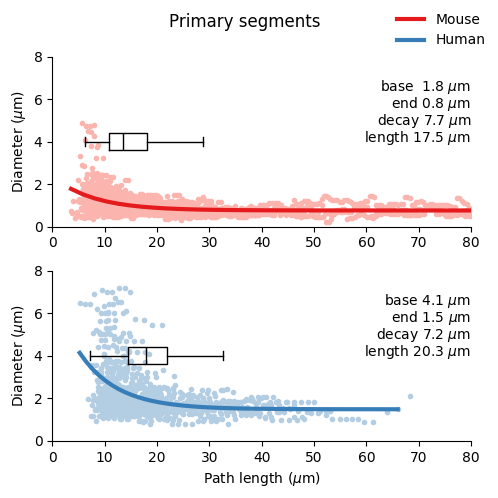

In [13]:
fig = plt.figure(figsize=(5,5))
#fig.suptitle('Primary sections')
fig.suptitle('Primary segments')

mtypes = np.array([x[T] for x in mseg])
morder = np.array([x[ORDER] for x in mseg])
mbreadth = np.array([x[BREADTH] for x in mseg])
mpath = np.array([x[XSEC] for x in mseg])
mdiam = 2 * np.array([x[R] for x in mseg])
msel = (mtypes == SWC.DEND) * (morder == 1) * (mbreadth != 1)
mx = mpath[msel]
my = mdiam[msel]
#mselfit = (mx < np.mean(mx))
mselfit = (mx < np.max(mx))
mxfit = mx[mselfit]
myfit = my[mselfit]
mpopt, _ = curve_fit(exponential, mxfit, myfit)
mxline = np.linspace(min(mxfit), max(mxfit))
myline = exponential(mxline, *mpopt)
mpoptprime = mpopt
print(f'{mpoptprime=}')

msec_types = np.array([x[SEC_T] for x in msec])
msec_order = np.array([x[SEC_ORDER] for x in msec])
msec_breadth = np.array([x[SEC_BREADTH] for x in msec])
msec_length = np.array([x[SEC_LEN] for x in msec])
msec_sel = (msec_types == SWC.DEND) * (msec_order == 1) * (msec_breadth != 1)
msec_len = msec_length[msec_sel]
mlenprime = np.mean(msec_len)

htypes = np.array([x[T] for x in hseg])
horder = np.array([x[ORDER] for x in hseg])
hbreadth = np.array([x[BREADTH] for x in hseg])
hpath = np.array([x[XSEC] for x in hseg])
hdiam = 2 * np.array([x[R] for x in hseg])
hsel = (htypes == SWC.DEND) * (horder == 1) * (hbreadth != 1)
hx = hpath[hsel]
hy = hdiam[hsel]
#hselfit = (hx < np.mean(hx))
hselfit = (hx < np.max(hx))
hxfit = hx[hselfit]
hyfit = hy[hselfit]
hpopt, _ = curve_fit(exponential, hxfit, hyfit)
hxline = np.linspace(min(hxfit), max(hxfit))
hyline = exponential(hxline, *hpopt)
hpoptprime = hpopt
print(f'{hpoptprime=}')

hsec_types = np.array([x[SEC_T] for x in hsec])
hsec_order = np.array([x[SEC_ORDER] for x in hsec])
hsec_breadth = np.array([x[SEC_BREADTH] for x in hsec])
hsec_length = np.array([x[SEC_LEN] for x in hsec])
hsec_sel = (hsec_types == SWC.DEND) * (hsec_order == 1) * (hsec_breadth != 1)
hsec_len = hsec_length[hsec_sel]
hlenprime = np.mean(hsec_len)

xmax = max(max(mx), max(hx)) + 1.0
ymax = int(max(max(my), max(hy))) + 1

ax = fig.add_subplot(2, 1, 1)
ax.set_ylabel('Diameter ($\mu$m)')
ax.plot(mx, my, '.', color=mcolor_light)
ax.plot(mxline, myline, color=mcolor, linewidth=3, label='Mouse')
ax.boxplot(msec_len, positions=[ymax/2], widths=[ymax/10], vert=False, 
           showfliers=False, medianprops={'color': 'black'})
ax.text(1.0, 0.8, f'base  {exponential(min(mxfit), mpopt[0], mpopt[1], mpopt[2]):.1f} $\mu$m', 
        ha='right', transform=ax.transAxes)
ax.text(1.0, 0.7, f'end {mpopt[2]:.1f} $\mu$m', ha='right', transform=ax.transAxes)
ax.text(1.0, 0.6, f'decay {mpopt[1]:.1f} $\mu$m', ha='right', transform=ax.transAxes)
ax.text(1.0, 0.5, f'length {np.mean(msec_len):.1f} $\mu$m', ha='right', transform=ax.transAxes)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_yticks(range(0, ymax+1, 2), [str(d) for d in range(0, ymax+1, 2)])
ax.set_ylim(0, ymax)
#ax.set_xlim(0, xmax)
ax.set_xlim(0, 80)

ax = fig.add_subplot(2, 1, 2)
ax.set_ylabel('Diameter ($\mu$m)')
ax.set_xlabel('Path length ($\mu$m)')
ax.plot(hx, hy, '.', color=hcolor_light)
ax.plot(hxline, hyline, color=hcolor, linewidth=3, label='Human')
ax.boxplot(hsec_len, positions=[ymax/2], widths=[ymax/10], vert=False, 
           showfliers=False, medianprops={'color': 'black'})
ax.text(1.0, 0.8, f'base {exponential(min(hxfit), hpopt[0], hpopt[1], hpopt[2]):.1f} $\mu$m', 
        ha='right', transform=ax.transAxes)
ax.text(1.0, 0.7, f'end {hpopt[2]:.1f} $\mu$m', ha='right', transform=ax.transAxes)
ax.text(1.0, 0.6, f'decay {hpopt[1]:.1f} $\mu$m', ha='right', transform=ax.transAxes)
ax.text(1.0, 0.5, f'length {np.mean(hsec_len):.1f} $\mu$m', ha='right', transform=ax.transAxes)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_yticks(range(0, ymax+1, 2), [str(d) for d in range(0, ymax+1, 2)])
ax.set_ylim(0, ymax)
#ax.set_xlim(0, xmax)
ax.set_xlim(0, 80)

fig.legend(frameon=False)
fig.tight_layout();
fig.savefig('images/seg-diam-1.pdf')

## Intermediate dendrites

mpoptinter=array([5.96426948e-04, 7.31035671e-01])
hpoptinter=array([0.89698424, 5.59697121, 1.1478651 ])


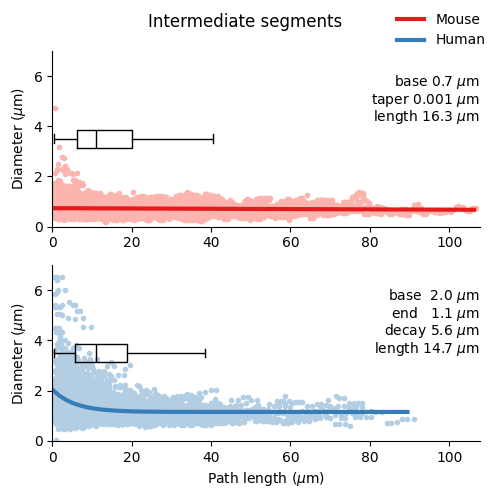

In [14]:
fig = plt.figure(figsize=(5,5))
#fig.suptitle('Intermediate sections')
fig.suptitle('Intermediate segments')

mtypes = np.array([x[T] for x in mseg])
morder = np.array([x[ORDER] for x in mseg])
mbreadth = np.array([x[BREADTH] for x in mseg])
mpath = np.array([x[XSEC] for x in mseg])
mdiam = 2 * np.array([x[R] for x in mseg])
msel = (mtypes == SWC.DEND) * (morder != 1) * (mbreadth != 1)
mx = mpath[msel]
my = mdiam[msel]
#mselfit = (mx < np.mean(mx))
mselfit = (mx < np.max(mx))
mxfit = mx[mselfit]
myfit = my[mselfit]
mpopt, _ = curve_fit(linear, mxfit, myfit)
mxline = np.linspace(min(mxfit), max(mxfit))
myline = linear(mxline, *mpopt)
mpoptinter = mpopt
print(f'{mpoptinter=}')

msec_types = np.array([x[SEC_T] for x in msec])
msec_order = np.array([x[SEC_ORDER] for x in msec])
msec_breadth = np.array([x[SEC_BREADTH] for x in msec])
msec_length = np.array([x[SEC_LEN] for x in msec])
msec_sel = (msec_types == SWC.DEND) * (msec_order != 1) * (msec_breadth != 1)
msec_len = msec_length[msec_sel]
mleninter = np.mean(msec_len)

htypes = np.array([x[T] for x in hseg])
horder = np.array([x[ORDER] for x in hseg])
hbreadth = np.array([x[BREADTH] for x in hseg])
hpath = np.array([x[XSEC] for x in hseg])
hdiam = 2 * np.array([x[R] for x in hseg])
hsel = (htypes == SWC.DEND) * (horder != 1) * (hbreadth != 1)
hx = hpath[hsel]
hy = hdiam[hsel]
#hselfit = (hx < np.mean(hx))
hselfit = (hx < np.max(hx))
hxfit = hx[hselfit]
hyfit = hy[hselfit]
hpopt, _ = curve_fit(exponential, hxfit, hyfit)
#hpopt, _ = curve_fit(linear, hxfit, hyfit)
hxline = np.linspace(min(hxfit), max(hxfit))
hyline = exponential(hxline, *hpopt)
#hyline = linear(hxline, *hpopt)
hpoptinter = hpopt
print(f'{hpoptinter=}')

hsec_types = np.array([x[SEC_T] for x in hsec])
hsec_order = np.array([x[SEC_ORDER] for x in hsec])
hsec_breadth = np.array([x[SEC_BREADTH] for x in hsec])
hsec_length = np.array([x[SEC_LEN] for x in hsec])
hsec_sel = (hsec_types == SWC.DEND) * (hsec_order != 1) * (hsec_breadth != 1)
hsec_len = hsec_length[hsec_sel]
hleninter = np.mean(hsec_len)

xmax = max(max(mx), max(hx)) + 1.0
ymax = int(max(max(my), max(hy))) + 1

ax = fig.add_subplot(2, 1, 1)
ax.set_ylabel('Diameter ($\mu$m)')
ax.plot(mx, my, '.', color=mcolor_light)
ax.plot(mxline, myline, color=mcolor, linewidth=3, label='Mouse')
ax.boxplot(msec_len, positions=[ymax/2], widths=[ymax/10], vert=False, 
           showfliers=False, medianprops={'color': 'black'})
ax.text(1.0, 0.8, f'base {linear(min(mxfit), mpopt[0], mpopt[1]):.1f} $\mu$m', 
        ha='right', transform=ax.transAxes)
ax.text(1.0, 0.7, f'taper {mpopt[0]:.3f} $\mu$m', ha='right', transform=ax.transAxes)
ax.text(1.0, 0.6, f'length {np.mean(msec_len):.1f} $\mu$m', ha='right', transform=ax.transAxes)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_yticks(range(0, ymax+1, 2), [str(d) for d in range(0, ymax+1, 2)])
ax.set_ylim(0, ymax)
ax.set_xlim(0, xmax)

ax = fig.add_subplot(2, 1, 2)
ax.set_ylabel('Diameter ($\mu$m)')
ax.set_xlabel('Path length ($\mu$m)')
ax.plot(hx, hy, '.', color=hcolor_light)
ax.plot(hxline, hyline, color=hcolor, linewidth=3, label='Human')
ax.boxplot(hsec_len, positions=[ymax/2], widths=[ymax/10], vert=False, 
           showfliers=False, medianprops={'color': 'black'})
ax.text(1.0, 0.8, f'base  {exponential(min(hxfit), hpopt[0], hpopt[1], hpopt[2]):.1f} $\mu$m', 
        ha='right', transform=ax.transAxes)
ax.text(1.0, 0.7, f'end   {hpopt[2]:.1f} $\mu$m', ha='right', transform=ax.transAxes)
ax.text(1.0, 0.6, f'decay {hpopt[1]:.1f} $\mu$m', ha='right', transform=ax.transAxes)
ax.text(1.0, 0.5, f'length {np.mean(hsec_len):.1f} $\mu$m', ha='right', transform=ax.transAxes)

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_yticks(range(0, ymax+1, 2), [str(d) for d in range(0, ymax+1, 2)])
ax.set_ylim(0, ymax)
ax.set_xlim(0, xmax)

fig.legend(frameon=False)
fig.tight_layout()
fig.savefig('images/seg-diam-2.pdf')

## Terminal dendrites

In [15]:
hseg_term = []
for rec in glob('../data/human/derived/sanitized/*.swc'):
        hseg_term += load_segdata(rec)

In [16]:
mseg_term = []
for rec in glob('../data/mouse/derived/sanitized/*.swc'):
    mseg_term += load_segdata(rec)

In [17]:
hsec_term = []
for rec in glob('../data/human/derived/sanitized/*.swc'):
        hsec_term += load_secdata(rec)

In [18]:
msec_term = []
for rec in glob('../data/mouse/derived/sanitized/*.swc'):
    msec_term += load_secdata(rec)

mpoptterm=array([-3.19955347e-04,  6.17714576e-01])
hpoptterm=array([1.15331185e-04, 9.85996206e-01])


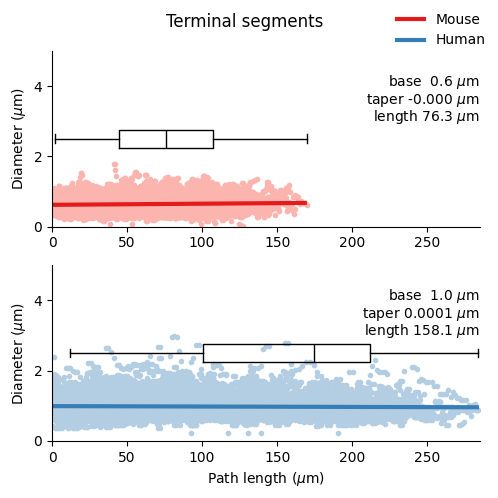

In [19]:
fig = plt.figure(figsize=(5,5))
#fig.suptitle('Terminal sections')
fig.suptitle('Terminal segments')

mtypes = np.array([x[T] for x in mseg_term])
#morder = np.array([x[ORDER] for x in mseg_term])
mbreadth = np.array([x[BREADTH] for x in mseg_term])
mpath = np.array([x[XSEC] for x in mseg_term])
mdiam = 2 * np.array([x[R] for x in mseg_term])
msel = (mtypes == SWC.DEND) * (mbreadth == 1)
mx = mpath[msel]
my = mdiam[msel]
#mselfit = (mx < np.mean(mx))
mselfit = (mx < np.max(mx))
mxfit = mx[mselfit]
myfit = my[mselfit]
mpopt, _ = curve_fit(linear, mxfit, myfit)
mxline = np.linspace(min(mxfit), max(mxfit))
myline = linear(mxline, *mpopt)
mpoptterm = mpopt
print(f'{mpoptterm=}')

msec_types = np.array([x[SEC_T] for x in msec_term])
#msec_order = np.array([x[SEC_ORDER] for x in msec_term])
msec_breadth = np.array([x[SEC_BREADTH] for x in msec_term])
msec_length = np.array([x[SEC_LEN] for x in msec_term])
msec_sel = (msec_types == SWC.DEND) * (msec_breadth == 1)
msec_len = msec_length[msec_sel]
mlenterm = np.mean(msec_len)

htypes = np.array([x[T] for x in hseg_term])
#horder = np.array([x[ORDER] for x in hseg_term])
hbreadth = np.array([x[BREADTH] for x in hseg_term])
hpath = np.array([x[XSEC] for x in hseg_term])
hdiam = 2 * np.array([x[R] for x in hseg_term])
hsel = (htypes == SWC.DEND) * (hbreadth == 1)
hx = hpath[hsel]
hy = hdiam[hsel]
#hselfit = (hx < np.mean(hx))
hselfit = (hx < np.max(hx))
hxfit = hx[hselfit]
hyfit = hy[hselfit]
hpopt, _ = curve_fit(linear, hxfit, hyfit)
hxline = np.linspace(min(hxfit), max(hxfit))
hyline = linear(hxline, *hpopt)
hpoptterm = hpopt
print(f'{hpoptterm=}')

hsec_types = np.array([x[SEC_T] for x in hsec_term])
#hsec_order = np.array([x[SEC_ORDER] for x in hsec_term])
hsec_breadth = np.array([x[SEC_BREADTH] for x in hsec_term])
hsec_length = np.array([x[SEC_LEN] for x in hsec_term])
hsec_sel = (hsec_types == SWC.DEND) * (hsec_breadth == 1)
hsec_len = hsec_length[hsec_sel]
hlenterm = np.mean(hsec_len)

xmax = max(max(mx), max(hx)) + 1.0
ymax = 5 #int(max(max(my), max(hy))) + 1

ax = fig.add_subplot(2, 1, 1)
ax.set_ylabel('Diameter ($\mu$m)')
ax.plot(mx, my, '.', color=mcolor_light)
ax.plot(mxline, myline, color=mcolor, linewidth=3, label='Mouse')
ax.boxplot(msec_len, positions=[ymax/2], widths=[ymax/10], vert=False, 
           showfliers=False, medianprops={'color': 'black'})
ax.text(1.0, 0.8, f'base  {linear(min(mxfit), mpopt[0], mpopt[1]):.1f} $\mu$m', 
        ha='right', transform=ax.transAxes)
ax.text(1.0, 0.7, f'taper {mpopt[0]:.3f} $\mu$m', ha='right', transform=ax.transAxes)
ax.text(1.0, 0.6, f'length {np.mean(msec_len):.1f} $\mu$m', ha='right', transform=ax.transAxes)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_yticks(range(0, ymax+1, 2), [str(d) for d in range(0, ymax+1, 2)])
ax.set_ylim(0, ymax)
ax.set_xlim(0, xmax)

ax = fig.add_subplot(2, 1, 2)
ax.set_ylabel('Diameter ($\mu$m)')
ax.set_xlabel('Path length ($\mu$m)')
ax.plot(hx, hy, '.', color=hcolor_light)
ax.plot(hxline, hyline, color=hcolor, linewidth=3, label='Human')
ax.boxplot(hsec_len, positions=[ymax/2], widths=[ymax/10], vert=False, 
           showfliers=False, medianprops={'color': 'black'})
ax.text(1.0, 0.8, f'base  {linear(min(hxfit), hpopt[0], hpopt[1]):.1f} $\mu$m', 
        ha='right', transform=ax.transAxes)
ax.text(1.0, 0.7, f'taper {hpopt[0]:.4f} $\mu$m', ha='right', transform=ax.transAxes)
ax.text(1.0, 0.6, f'length {np.mean(hsec_len):.1f} $\mu$m', ha='right', transform=ax.transAxes)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_yticks(range(0, ymax+1, 2), [str(d) for d in range(0, ymax+1, 2)])
ax.set_ylim(0, ymax)
ax.set_xlim(0, xmax)

fig.legend(frameon=False)
fig.tight_layout()
fig.savefig('images/seg-diam-3.pdf')

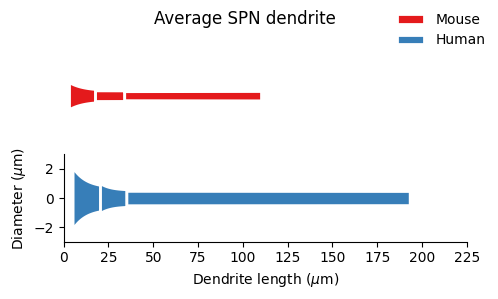

In [20]:
fig = plt.figure(figsize=(5,3))
fig.suptitle('Average SPN dendrite')

ax = fig.add_subplot(2, 1, 1)

mxprime = np.linspace(3, mlenprime)
myprime = exponential(mxprime, *mpoptprime) / 2
ax.fill_between(mxprime, myprime, -myprime, color=mcolor, edgecolor='white', linewidth=2, label='Mouse')

mxinner = np.linspace(0, mleninter)
myinner = linear(mxinner, *mpoptinter) / 2
ax.fill_between(mxinner + mlenprime, myinner, -myinner, color=mcolor, edgecolor='white', linewidth=2)

mxterm = np.linspace(0, mlenterm)
myterm = linear(mxterm, *mpoptterm) / 2
ax.fill_between(mxterm + mlenprime + mleninter, myterm, -myterm, color=mcolor, edgecolor='white', linewidth=2)

ax.set_ylim(-3, 3)
ax.set_xlim(0, 225)
ax.axis('off')

ax = fig.add_subplot(2, 1, 2)

hxprime = np.linspace(5, hlenprime)
hyprime = exponential(hxprime, *hpoptprime) / 2
ax.fill_between(hxprime, hyprime, -hyprime, color=hcolor, edgecolor='white', linewidth=2, label='Human')

hxinner = np.linspace(0, hleninter)
hyinner = exponential(hxinner, *hpoptinter) / 2
ax.fill_between(hxinner + hlenprime, hyinner, -hyinner, color=hcolor, edgecolor='white', linewidth=2)

hxterm = np.linspace(0, hlenterm)
hyterm = linear(hxterm, *hpoptterm) / 2
ax.fill_between(hxterm + hlenprime + hleninter, hyterm, -hyterm, color=hcolor, edgecolor='white', linewidth=2)

ax.set_ylim(-3, 3)
ax.set_xlim(0, 225)
ax.set_ylabel('Diameter ($\mu$m)')
ax.set_xlabel('Dendrite length ($\mu$m)')
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

fig.legend(frameon=False)
fig.tight_layout()
fig.savefig('images/seg-diam-4.pdf')

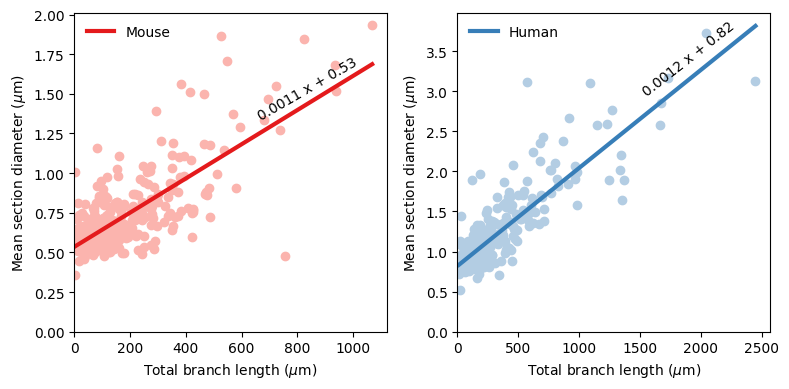

In [21]:
fig = plt.figure(figsize=(8,4))

ax = fig.add_subplot(1, 2, 1)
ax.set_ylabel('Mean section diameter ($\mu$m)')
ax.set_xlabel('Total branch length ($\mu$m)')
msec_types = np.array([x[SEC_T] for x in msec_term])
msec_totlen = np.array([x[SEC_TOTLEN] for x in msec_term])
msec_diam = np.array([x[SEC_DIAM] for x in msec_term])
msec_sel = (msec_types == SWC.DEND)
mx = msec_totlen[msec_sel]
my = msec_diam[msec_sel]

mselfit = (mx <= np.max(mx))
mxfit = mx[mselfit]
myfit = my[mselfit]
mpopt, _ = curve_fit(linear, mxfit, myfit)
mxline = np.linspace(min(mxfit), max(mxfit))
myline = linear(mxline, *mpopt)
a, b = mpopt
a = -a
ax.plot(mx, my, 'o', color=mcolor_light)
ax.plot(mxline, myline, color=mcolor, linewidth=3, label='Mouse')
ax.text(650, linear(650, *mpopt)+0.1, f'{a:.4f} x + {b:.2f}', rotation=30)
ax.legend(frameon=False)
ax.set_ylim(bottom=0)
ax.set_xlim(left=0)

ax = fig.add_subplot(1, 2, 2)
ax.set_ylabel('Mean section diameter ($\mu$m)')
ax.set_xlabel('Total branch length ($\mu$m)')
hsec_types = np.array([x[SEC_T] for x in hsec_term])
hsec_totlen = np.array([x[SEC_TOTLEN] for x in hsec_term])
hsec_diam = np.array([x[SEC_DIAM] for x in hsec_term])
hsec_sel = (hsec_types == SWC.DEND)
hx = hsec_totlen[hsec_sel]
hy = hsec_diam[hsec_sel]

hselfit = (hx <= np.max(hx))
hxfit = hx[hselfit]
hyfit = hy[hselfit]
hpopt, _ = curve_fit(linear, hxfit, hyfit)
hxline = np.linspace(min(hxfit), max(hxfit))
hyline = linear(hxline, *hpopt)
a, b = hpopt
a = -a
ax.plot(hx, hy, 'o', color=hcolor_light)
ax.plot(hxline, hyline, color=hcolor, linewidth=3, label='Human')
ax.text(1500, linear(1500, *hpopt)+0.3, f'{a:.4f} x + {b:.2f}', rotation=38)
ax.legend(frameon=False)
ax.set_ylim(bottom=0)
ax.set_xlim(left=0)

fig.tight_layout()
fig.savefig('images/seg-diam-4.pdf')

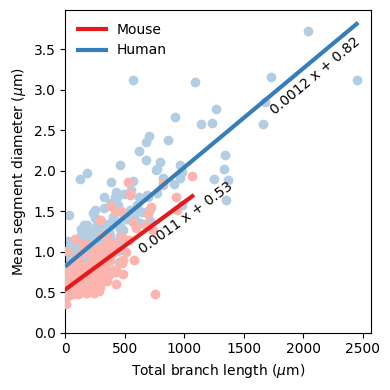

In [22]:
fig = plt.figure(figsize=(4,4))
#fig.suptitle("")

ax = fig.add_subplot(1, 1, 1)
#ax.set_ylabel('Mean section diameter ($\mu$m)')
ax.set_ylabel('Mean segment diameter ($\mu$m)')
ax.set_xlabel('Total branch length ($\mu$m)')
msec_types = np.array([x[SEC_T] for x in msec_term])
msec_totlen = np.array([x[SEC_TOTLEN] for x in msec_term])
msec_diam = np.array([x[SEC_DIAM] for x in msec_term])
msec_sel = (msec_types == SWC.DEND)
mx = msec_totlen[msec_sel]
my = msec_diam[msec_sel]

mselfit = (mx <= np.max(mx))
mxfit = mx[mselfit]
myfit = my[mselfit]
mpopt, _ = curve_fit(linear, mxfit, myfit)
mxline = np.linspace(min(mxfit), max(mxfit))
myline = linear(mxline, *mpopt)
a, b = mpopt
a = -a
ax.plot(mx, my, 'o', color=mcolor_light, zorder=3)
ax.plot(mxline, myline, color=mcolor, linewidth=3, zorder=3, label='Mouse')
ax.text(600, linear(500, *mpopt)-0.1, f'{a:.4f} x + {b:.2f}', rotation=36)

hsec_types = np.array([x[SEC_T] for x in hsec_term])
hsec_totlen = np.array([x[SEC_TOTLEN] for x in hsec_term])
hsec_diam = np.array([x[SEC_DIAM] for x in hsec_term])
hsec_sel = (hsec_types == SWC.DEND)
hx = hsec_totlen[hsec_sel]
hy = hsec_diam[hsec_sel]

hselfit = (hx <= np.max(hx))
hxfit = hx[hselfit]
hyfit = hy[hselfit]
hpopt, _ = curve_fit(linear, hxfit, hyfit)
hxline = np.linspace(min(hxfit), max(hxfit))
hyline = linear(hxline, *hpopt)
a, b = hpopt
a = -a
ax.plot(hx, hy, 'o', color=hcolor_light)
ax.plot(hxline, hyline, color=hcolor, linewidth=3, zorder=3, label='Human')
ax.text(1700, linear(1700, *hpopt)-0.2, f'{a:.4f} x + {b:.2f}', rotation=40)
ax.legend(frameon=False)
ax.set_ylim(bottom=0)
ax.set_xlim(left=0)

fig.tight_layout()
fig.savefig('images/seg-diam-5.pdf')